In [122]:
import yfinance as yf
import datetime
import pandas as pd
import seaborn
import dateutil
import collections
import bs4 as bs4
import requests

Get AAPL Data

In [123]:
aapl = yf.Ticker("aapl").history(period = "5y")

/Users/aman2/anaconda3/envs/ollama_lang_chrome_test/lib/python3.10/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


In [124]:
assert not aapl.empty

<Axes: xlabel='Date', ylabel='Close'>

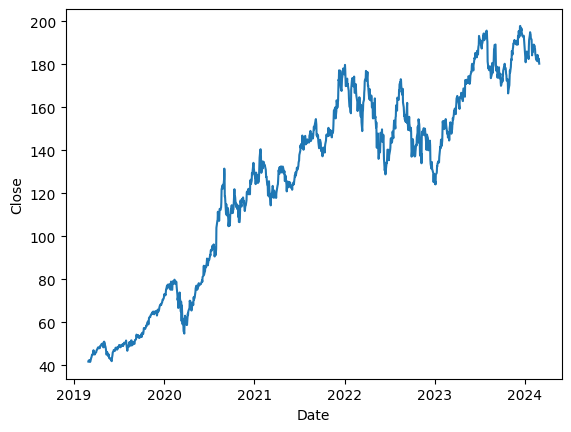

In [125]:
seaborn.lineplot(data = aapl, x = "Date", y = "Close")

In [126]:
aapl = aapl.reset_index()
aapl["Date"] = aapl["Date"].dt.date
aapl.set_index("Date")

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2019-02-28,41.954414,42.096411,41.617467,41.672821,112861600,0.0,0.0
2019-03-01,41.944793,42.154179,41.610255,42.110859,103544800,0.0,0.0
2019-03-04,42.284150,42.779939,41.870189,42.322659,109744800,0.0,0.0
2019-03-05,42.344314,42.358753,42.007367,42.245636,78949600,0.0,0.0
2019-03-06,42.038656,42.236011,41.862964,42.002556,83241600,0.0,0.0
...,...,...,...,...,...,...,...
2024-02-23,185.009995,185.039993,182.229996,182.520004,45074500,0.0,0.0
2024-02-26,182.240005,182.759995,180.649994,181.160004,40867400,0.0,0.0
2024-02-27,181.100006,183.919998,179.559998,182.630005,54318900,0.0,0.0


In [127]:
import dateutil.parser
aapl['week'] = aapl['Date'].apply(lambda x: x.isocalendar()[1])
aapl['year'] = aapl['Date'].apply(lambda x: x.year)
aapl['day_of_week'] = aapl['Date'].apply(lambda x: x.isocalendar()[2])
aapl.set_index("Date")

,Open,High,Low,Close,Volume,Dividends,Stock Splits,week,year,day_of_week
Date,,,,,,,,,,
2019-02-28,41.954414,42.096411,41.617467,41.672821,112861600,0.0,0.0,9,2019,4
2019-03-01,41.944793,42.154179,41.610255,42.110859,103544800,0.0,0.0,9,2019,5
2019-03-04,42.284150,42.779939,41.870189,42.322659,109744800,0.0,0.0,10,2019,1
2019-03-05,42.344314,42.358753,42.007367,42.245636,78949600,0.0,0.0,10,2019,2
2019-03-06,42.038656,42.236011,41.862964,42.002556,83241600,0.0,0.0,10,2019,3
...,...,...,...,...,...,...,...,...,...,...
2024-02-23,185.009995,185.039993,182.229996,182.520004,45074500,0.0,0.0,8,2024,5
2024-02-26,182.240005,182.759995,180.649994,181.160004,40867400,0.0,0.0,9,2024,1
2024-02-27,181.100006,183.919998,179.559998,182.630005,54318900,0.0,0.0,9,2024,2


In [128]:
daily_open_close = aapl.groupby(by=["year","week","day_of_week"])[["Open","Close"]].mean()

In [129]:
open_close = daily_open_close.reset_index("day_of_week")
grouped = open_close.groupby(by=["year","week"])
open_close["start_of_week"] = grouped[["day_of_week"]].min()
open_close["end_of_week"] = grouped[["day_of_week"]].max()
open_close

day_of_week        Open       Close  start_of_week  end_of_week
year week                                                                 
2019 1               1   70.410448   70.911537              1            2
     1               2   70.524776   71.429657              1            2
     9               4   41.954414   41.672821              4            5
     9               5   41.944793   42.110859              4            5
     10              1   42.284150   42.322659              1            5
...                ...         ...         ...            ...          ...
2024 8               5  185.009995  182.520004              2            5
     9               1  182.240005  181.160004              1            4
     9               2  181.100006  182.630005              1            4
     9               3  182.509995  181.419998              1            4
     9               4  181.270004  180.294998              1            4

[1260 rows x 5 columns]

In [130]:
unique_weeks = open_close.reset_index()[["year","week","start_of_week","end_of_week"]].drop_duplicates()
weekly_opens = unique_weeks.rename(columns = {"start_of_week":"day_of_week"}).set_index(["year","week","day_of_week"]).join(daily_open_close["Open"]).drop(columns = ["end_of_week"]).reset_index().set_index(["year","week"]).drop(columns="day_of_week")
weekly_closes = unique_weeks.rename(columns = {"end_of_week":"day_of_week"}).set_index(["year","week","day_of_week"]).join(daily_open_close["Close"]).drop(columns = ["start_of_week"]).reset_index().set_index(["year","week"]).drop(columns="day_of_week")
unique_weeks = unique_weeks.set_index(["year","week"])
unique_weeks["Open"] = weekly_opens
unique_weeks["Close"] = weekly_closes
unique_weeks.drop(columns=["start_of_week","end_of_week"], inplace=True)
unique_weeks

Open       Close
year week                        
2019 1      70.410448   71.429657
     9      41.954414   42.110859
     10     42.284150   41.615074
     11     42.236007   44.794376
     12     44.717369   45.980907
...               ...         ...
2024 5     191.765299  185.613159
     6     187.910213  188.850006
     7     188.419998  182.309998
     8     181.789993  182.520004
     9     182.240005  180.294998

[263 rows x 2 columns]

In [132]:
unique_weeks.to_csv(".data/cleaned_stock_data.csv")